In [1]:
%load_ext autoreload
%autoreload 2

import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

# Load MNIST from OpenML

In [ ]:
X, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False)

In [3]:
y_mc = y_mc.astype(int)
# make it a binary classification problem for the sake of simplicity
y = y_mc >= 5
xtrain, xtest, ytrain, ytest, ytrain_mc, ytest_mc = train_test_split(X, y, y_mc, test_size=0.2, shuffle=True)

# Train an XGBoost model

In [4]:
import veritas
import xgboost as xgb
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [5]:
params = {
    "n_estimators": 50,
    #"num_class": 10,
    #"objective": "multi:softmax",
    #"eval_metric": "merror",
    "eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 7,
    "learning_rate": 0.2,
    "colsample_bynode": 0.75,
    "subsample": 0.5
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 8.443722248077393 seconds


In [6]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.984, test acc: 0.983 wrt true labels


# Generate adversarial examples

In [7]:
# FROM CLASS 0 -> CLASS 1
number_of_adv_examples = 5

rng = np.random.default_rng(seed=128)
xtest0 = xtest[ytest==0, :]
subset = xtest0[rng.choice(range(xtest0.shape[0]), number_of_adv_examples), :]

eps = 10

In [8]:
feat2id = lambda s: int(s[1:])
at = veritas.get_addtree(model)

base_score according to XGB: 0.5
base_score set to 0.0 if base_score was 0.5


In [9]:
adv_examples = []
for i in tqdm.tqdm(range(subset.shape[0])):
    base_example = subset[i, :]

    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.ignore_state_when_worse_than = 0.0

    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    search = config.get_search(at, prune_box)

    tstart = time.time()
    while search.num_solutions() == 0:
        if search.steps(100) == veritas.StopReason.NO_MORE_OPEN:
            break
    tstop = time.time()

    if search.num_solutions() > 0:
        sol = search.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, eps=1e-3)

        res = {"i": i, "adv_example": adv_example, "base_example": base_example}

        res["base_ypred_at"] = at.predict(np.atleast_2d(base_example))[0,0]
        res["base_ypred"] = model.predict_proba(np.atleast_2d(base_example))[0,1]
        res["adv_ypred"] = model.predict_proba(np.atleast_2d(adv_example))[0,1]
        res["adv_ypred_at"] = at.predict(np.atleast_2d(adv_example))[0,0]

        adv_examples.append(res)
    else:
        print("no adversarial examples found for", i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 120.49it/s]


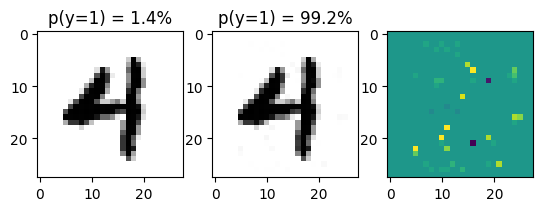

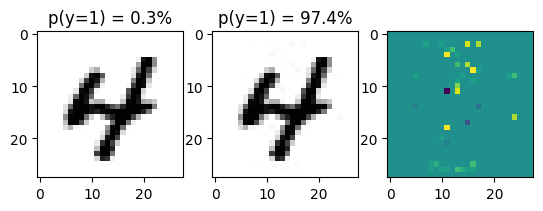

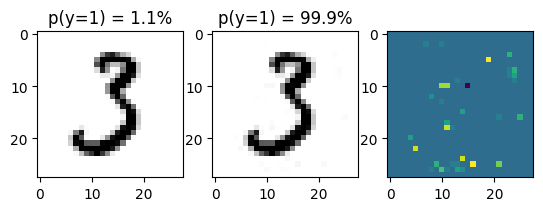

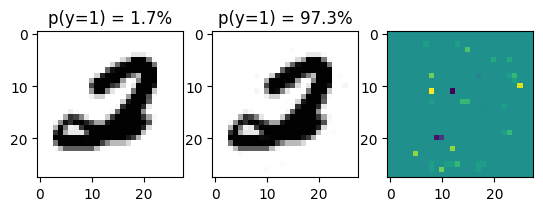

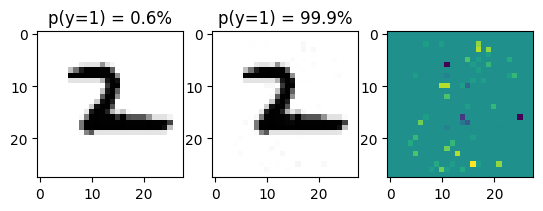

In [10]:
for i, res in enumerate(adv_examples):
    base_example = res["base_example"]
    adv_example = res["adv_example"]
    base_prob = res["base_ypred"]
    adv_prob = res["adv_ypred"]
    
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((base_example).reshape((28,28)), cmap="binary")
    ax[0].set_title(f"p(y=1) = {base_prob*100:.1f}%")
    ax[1].imshow((adv_example).reshape((28,28)), cmap="binary")
    ax[1].set_title(f"p(y=1) = {adv_prob*100:.1f}%")
    ax[2].imshow((adv_example-base_example).reshape((28,28)))
    
    plt.show()

# An alternative verification question:
## Can an image that only has a narrow non-black band in the middle ever get the positive class?

Veritas generated an example in 0.67ms, stop_reason=StopReason.NONE


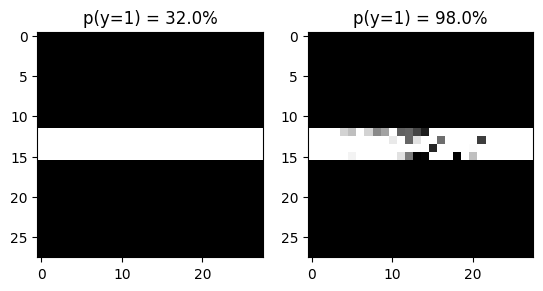

In [11]:
blackband = np.zeros(28*28)
blackband[0:28*12] = 255.0
blackband[28*16:] = 255.0

anything = veritas.Interval(0.0, 255.0)
black = veritas.Interval(255.0, 255.0)

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
config.ignore_state_when_worse_than = 0.0

prune_box = [black if x>0 else anything for x in blackband]
search = config.get_search(at, prune_box)

tstart = time.time()
while search.num_solutions() == 0:
    stop_reason = search.steps(100)
    if stop_reason == veritas.StopReason.NO_MORE_OPEN:
        break
tstop = time.time()

print(f"Veritas generated an example in {1000*(tstop-tstart):.2f}ms, stop_reason={stop_reason}")

sol = search.get_solution(0)
generated = veritas.get_closest_example(sol, blackband, eps=1e-3)

prob_blackband = at.predict(blackband)[0,0]
prob_generated = at.predict(generated)[0,0]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(blackband.reshape((28, 28)), cmap="binary")
ax[0].set_title(f"p(y=1) = {prob_blackband*100:.1f}%")
ax[1].imshow(generated.reshape((28, 28)), cmap="binary")
ax[1].set_title(f"p(y=1) = {prob_generated*100:.1f}%")
plt.show()

# Can we find a positive example with non-white pixels only in the top 3 rows of pixels?

Veritas generated an example in 0.14ms, stop_reason=StopReason.OPTIMAL


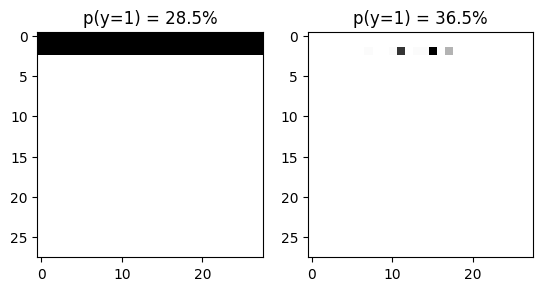

We proved that no such example exists!


In [12]:
allwhite = np.zeros(28*28)
whiteband = np.zeros(28*28)
whiteband[0:28*3] = 255.0

anything = veritas.Interval(0.0, 255.0)
white = veritas.Interval(0.0, 0.0)

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
#config.ignore_state_when_worse_than = 0.0

prune_box = [anything if x>0 else white for x in whiteband]
search = config.get_search(at, prune_box)

tstart = time.time()
while search.num_solutions() == 0:
    stop_reason = search.steps(100)
    if stop_reason == veritas.StopReason.NO_MORE_OPEN:
        break
tstop = time.time()

print(f"Veritas generated an example in {1000*(tstop-tstart):.2f}ms, stop_reason={stop_reason}")

sol = search.get_solution(0)
generated = veritas.get_closest_example(sol, allwhite, eps=1e-3)

prob_whiteband = at.predict(whiteband)[0,0]
prob_generated = at.predict(generated)[0,0]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(whiteband.reshape((28, 28)), cmap="binary")
ax[0].set_title(f"p(y=1) = {prob_whiteband*100:.1f}%")
ax[1].imshow(generated.reshape((28, 28)), cmap="binary")
ax[1].set_title(f"p(y=1) = {prob_generated*100:.1f}%")
plt.show()

if prob_generated < 0.5 and stop_reason == veritas.StopReason.OPTIMAL:
    print("We proved that no such example exists!")